In [1]:
#import boto3
#from sagemaker import get_execution_role
## Define IAM role
#role = get_execution_role()
#my_region = boto3.session.Session().region_name # set the region of the instance

In [2]:
#bucket_name = 'hsiehhw6' # <--- CHANGE THIS VARIABLE TO A UNIQUE NAME FOR YOUR BUCKET
#s3 = boto3.resource('s3')
#try:
#    if  my_region == 'us-east-1':
#      s3.create_bucket(Bucket=bucket_name)
#    else: 
#      s3.create_bucket(Bucket=bucket_name, CreateBucketConfiguration={ 'LocationConstraint': my_region })
#    print('S3 bucket created successfully')
#except Exception as e:
#    print('S3 error: ',e)

In [3]:
# To download data
!pwd
#!mkdir Data
!ls Data/faces
!mkdir Train
#!gdown --id 1gaFy8RaQVUEXo2n0peCBR5gYKCB-mNHc
#! pip install qqdm

/home/tsdc02/TH/ML_HYL_HWs/HW6
0.jpg	   19170.jpg  2833.jpg	 37509.jpg  46679.jpg  55848.jpg  65016.jpg
10000.jpg  19171.jpg  28340.jpg  3750.jpg   4667.jpg   55849.jpg  65017.jpg
10001.jpg  19172.jpg  28341.jpg  37510.jpg  46680.jpg  5584.jpg   65018.jpg
10002.jpg  19173.jpg  28342.jpg  37511.jpg  46681.jpg  55850.jpg  65019.jpg
10003.jpg  19174.jpg  28343.jpg  37512.jpg  46682.jpg  55851.jpg  6501.jpg
10004.jpg  19175.jpg  28344.jpg  37513.jpg  46683.jpg  55852.jpg  65020.jpg
10005.jpg  19176.jpg  28345.jpg  37514.jpg  46684.jpg  55853.jpg  65021.jpg
10006.jpg  19177.jpg  28346.jpg  37515.jpg  46685.jpg  55854.jpg  65022.jpg
10007.jpg  19178.jpg  28347.jpg  37516.jpg  46686.jpg  55855.jpg  65023.jpg
10008.jpg  19179.jpg  28348.jpg  37517.jpg  46687.jpg  55856.jpg  65024.jpg
10009.jpg  1917.jpg   28349.jpg  37518.jpg  46688.jpg  55857.jpg  65025.jpg
1000.jpg   19180.jpg  2834.jpg	 37519.jpg  46689.jpg  55858.jpg  65026.jpg
10010.jpg  19181.jpg  28350.jpg  3751.jpg   4668.jpg   55859.j

16547.jpg  25716.jpg  34886.jpg  44054.jpg  53223.jpg  62393.jpg  737.jpg
16548.jpg  25717.jpg  34887.jpg  44055.jpg  53224.jpg  62394.jpg  7380.jpg
16549.jpg  25718.jpg  34888.jpg  44056.jpg  53225.jpg  62395.jpg  7381.jpg
1654.jpg   25719.jpg  34889.jpg  44057.jpg  53226.jpg  62396.jpg  7382.jpg
16550.jpg  2571.jpg   3488.jpg	 44058.jpg  53227.jpg  62397.jpg  7383.jpg
16551.jpg  25720.jpg  34890.jpg  44059.jpg  53228.jpg  62398.jpg  7384.jpg
16552.jpg  25721.jpg  34891.jpg  4405.jpg   53229.jpg  62399.jpg  7385.jpg
16553.jpg  25722.jpg  34892.jpg  44060.jpg  5322.jpg   6239.jpg   7386.jpg
16554.jpg  25723.jpg  34893.jpg  44061.jpg  53230.jpg  623.jpg	  7387.jpg
16555.jpg  25724.jpg  34894.jpg  44062.jpg  53231.jpg  62400.jpg  7388.jpg
16556.jpg  25725.jpg  34895.jpg  44063.jpg  53232.jpg  62401.jpg  7389.jpg
16557.jpg  25726.jpg  34896.jpg  44064.jpg  53233.jpg  62402.jpg  738.jpg
16558.jpg  25727.jpg  34897.jpg  44065.jpg  53234.jpg  62403.jpg  7390.jpg
16559.jpg  25728.jpg  34898.j

mkdir: 無法建立目錄‘Train’: 檔案已存在


In [1]:
import os
import glob

import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch import optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
#!pip install qqdm
from qqdm.notebook import qqdm
import numpy as np
print(torchvision.__version__)

0.11.1+cu102


In [2]:
# To get data
def MyTransform(fname):
    # 1. Resize the image to (64, 64)
    # 2. Linearly map [0, 1] to [-1, 1]
    compose=[transforms.ToPILImage(),
            transforms.Resize((64,64)),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5))
        ]
    transform_pro=transforms.Compose(compose)
    img=transform_pro(fname)
    return img

class CrypkoDataset(Dataset):
    def __init__(self,data_path,transform):
        self.fnames=glob.glob(data_path+'/*.jpg')
        self.transform=transform
    def __getitem__(self,idx):
        fname=self.fnames[idx]
        img=torchvision.io.read_image(fname)
        img=self.transform(img)
        return img
    def __len__(self):
        return len(self.fnames)

dataset=CrypkoDataset('Data/faces/',MyTransform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of images: 71314


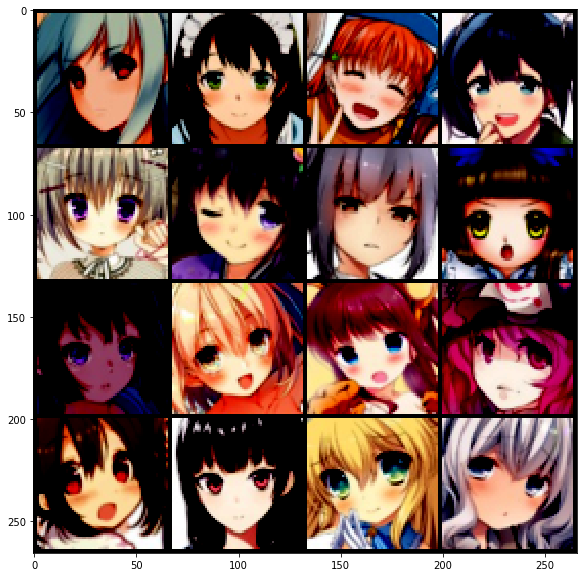

In [3]:
# Plot a few images
print('Number of images:',len(dataset))
rand_li=np.random.randint(len(dataset),size=16)
img_li=[dataset[i] for i in rand_li]
grid_img = torchvision.utils.make_grid(img_li, nrow=4)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

In [4]:
# Build models

class Generator(nn.Module):
    """
    Input shape: (N, in_dim)
    Output shape: (N, 3, 64, 64)
    """
    def __init__(self,in_dim, dim=64):   
        super(Generator,self).__init__()
        def dconv_bn_relu(in_dim, out_dim):
            conv=nn.Sequential(
                nn.ConvTranspose2d(in_dim, out_dim, kernel_size=5, stride=2,
                                   padding=2, output_padding=1, bias=False),
                nn.BatchNorm2d(out_dim),
                nn.ReLU()
            )
            return conv
        
        self.l1=nn.Sequential(
            nn.Linear(in_dim, dim * 8 * 4 * 4, bias=False),
            nn.BatchNorm1d(dim * 8 * 4 * 4),
            nn.ReLU()
        )        
        self.l2_5 = nn.Sequential(
            dconv_bn_relu(dim * 8, dim * 4),
            dconv_bn_relu(dim * 4, dim * 2),
            dconv_bn_relu(dim * 2, dim),
            nn.ConvTranspose2d(dim, 3, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.Tanh()
        )
    def forward(self,x):
        y=self.l1(x)
        y = y.view(y.size(0), -1, 4, 4)
        y=self.l2_5(y)
        return y

class Discriminator(nn.Module):
    """
    Input shape: (N, 3, 64, 64)
    Output shape: (N, )
    """
    def __init__(self, in_dim, dim=64):
        super(Discriminator, self).__init__()
        def conv_bn_lrelu(in_dim, out_dim):
            conv=nn.Sequential(
                nn.Conv2d(in_dim,out_dim, kernel_size=5, stride=2,
                            padding=2),
                nn.BatchNorm2d(out_dim),
                nn.LeakyReLU(0.2)
            )
            return conv
        """ Medium: Remove the last sigmoid layer for WGAN. """
        self.ls = nn.Sequential(
            nn.Conv2d(in_dim, dim, 5, 2, 2), 
            nn.LeakyReLU(0.2),
            conv_bn_lrelu(dim, dim * 2),
            conv_bn_lrelu(dim * 2, dim * 4),
            conv_bn_lrelu(dim * 4, dim * 8),
            nn.Conv2d(dim * 8, 1, 4),
            nn.Sigmoid()
        )
        
    def forward(self,x):
        y=self.ls(x)
        y = y.view(-1)
        return y
            

In [7]:
# Traning data setup
import torch
device='cuda' if torch.cuda.is_available() else 'cpu'
print(device)
ToContinum=True

# Hyperparameters
""" Medium: WGAN, 50 epoch, n_critic=5, clip_value=0.01 """
n_epoch = 20 # 50
n_critic = 5 # 5
# clip_value = 0.01

lr=1e-4
batch_size=64
z_dim=100

if ToContinum==False:
    z_sample = torch.randn(10, z_dim)
    torch.save(z_sample,'Models/z_sample.pt')

# Model
G=Generator(in_dim=z_dim).to(device)
D=Discriminator(in_dim=3).to(device)# not sure about the value
G.train()
D.train()

G_loss_li=[]
D_loss_li=[]
epoch_li=np.arange(n_epoch)

if ToContinum==True:
    z_sample=torch.load('Models/z_sample.pt')
    last=sorted(glob.glob('Models/G*.pth'))[-1][8:-4]
    print('epoch from ',last)
    G.load_state_dict(torch.load('Models/G'+last+'.pth'))
    D.load_state_dict(torch.load('Models/D'+last+'.pth'))
    epoch_li=epoch_li+int(last)
    G_loss_li=list(np.loadtxt('Models/G_loss.txt'))
    D_loss_li=list(np.loadtxt('Models/D_loss.txt'))

# Loss
criterion = nn.BCELoss()

""" Medium: Use RMSprop for WGAN. """
# Optimizer
opt_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
opt_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
# opt_D = torch.optim.RMSprop(D.parameters(), lr=lr)
# opt_G = torch.optim.RMSprop(G.parameters(), lr=lr)

dataloader=DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=8, drop_last=True)


cuda
epoch from  135


   Iters      Elapsed Time      Speed                                           
 1114/1114  00:01:52<00:00:00  9.91it/s                                         

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 | Save some samples to Train/135.jpg.


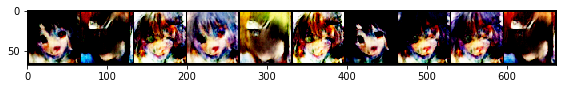

   Iters      Elapsed Time      Speed                                           
 1114/1114  00:01:52<00:00:00  9.88it/s                                         

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 | Save some samples to Train/136.jpg.


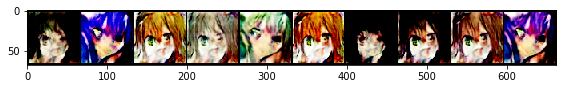

   Iters      Elapsed Time      Speed                                           
 1114/1114  00:01:52<00:00:00  9.87it/s                                         

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 | Save some samples to Train/137.jpg.


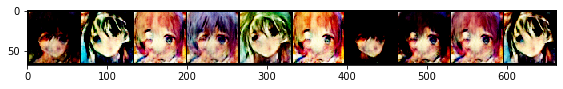

   Iters      Elapsed Time      Speed                                           
 1114/1114  00:01:53<00:00:00  9.84it/s                                         

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 | Save some samples to Train/138.jpg.


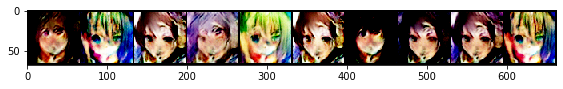

   Iters      Elapsed Time      Speed                                           
 1114/1114  00:01:53<00:00:00  9.83it/s                                         

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 | Save some samples to Train/139.jpg.


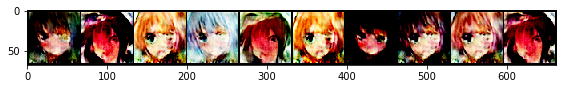

   Iters      Elapsed Time      Speed                                           
 1114/1114  00:01:53<00:00:00  9.82it/s                                         

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 | Save some samples to Train/140.jpg.


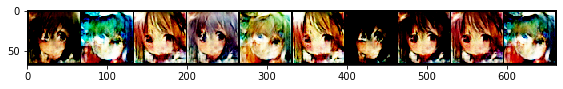

   Iters      Elapsed Time      Speed                                           
 1114/1114  00:01:53<00:00:00  9.81it/s                                         

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 | Save some samples to Train/141.jpg.


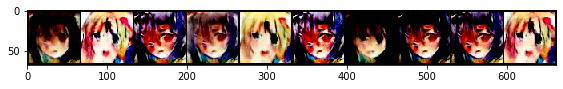

   Iters      Elapsed Time      Speed                                           
 1114/1114  00:01:53<00:00:00  9.81it/s                                         

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 | Save some samples to Train/142.jpg.


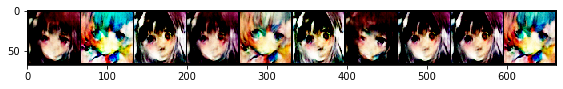

   Iters      Elapsed Time      Speed                                           
 1114/1114  00:01:53<00:00:00  9.82it/s                                         

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 | Save some samples to Train/143.jpg.


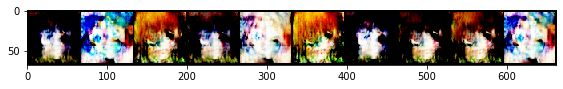

   Iters      Elapsed Time      Speed                                           
 1114/1114  00:01:53<00:00:00  9.83it/s                                         

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 | Save some samples to Train/144.jpg.


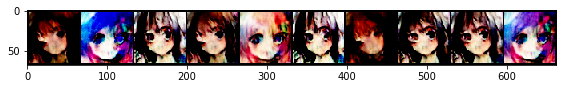

   Iters      Elapsed Time      Speed                                           
 1114/1114  00:01:53<00:00:00  9.81it/s                                         

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 | Save some samples to Train/145.jpg.


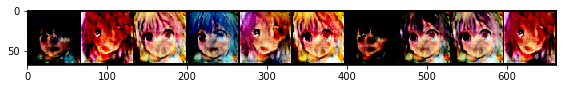

   Iters      Elapsed Time      Speed                                           
 1114/1114  00:01:53<00:00:00  9.80it/s                                         

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 | Save some samples to Train/146.jpg.


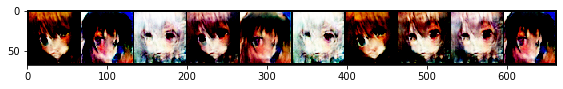

   Iters      Elapsed Time      Speed                                           
 1114/1114  00:01:53<00:00:00  9.80it/s                                         

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 | Save some samples to Train/147.jpg.


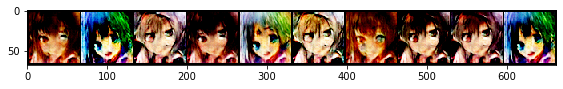

   Iters      Elapsed Time      Speed                                           
 1114/1114  00:01:53<00:00:00  9.81it/s                                         

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 | Save some samples to Train/148.jpg.


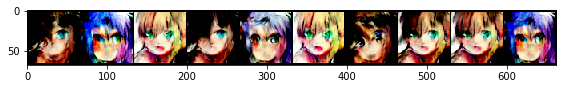

   Iters      Elapsed Time      Speed                                           
 1114/1114  00:01:53<00:00:00  9.81it/s                                         

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 | Save some samples to Train/149.jpg.


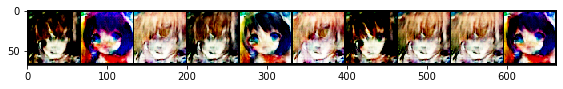

   Iters      Elapsed Time      Speed                                           
 1114/1114  00:01:53<00:00:00  9.80it/s                                         

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 | Save some samples to Train/150.jpg.


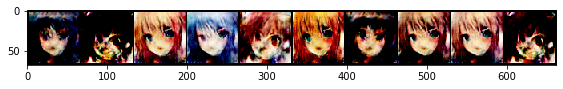

   Iters      Elapsed Time      Speed                                           
 1114/1114  00:01:53<00:00:00  9.79it/s                                         

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 | Save some samples to Train/151.jpg.


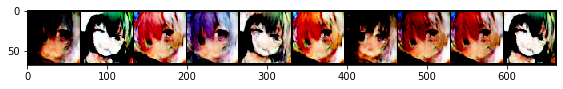

   Iters      Elapsed Time      Speed                                           
 1114/1114  00:01:53<00:00:00  9.80it/s                                         

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 | Save some samples to Train/152.jpg.


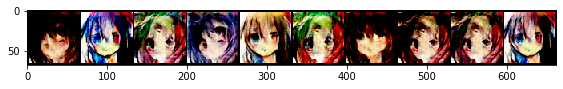

   Iters      Elapsed Time      Speed                                           
 1114/1114  00:01:53<00:00:00  9.80it/s                                         

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 | Save some samples to Train/153.jpg.


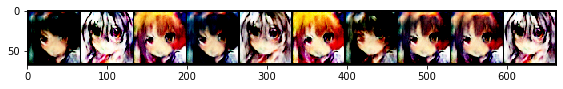

   Iters      Elapsed Time      Speed                                           
 1114/1114  00:01:53<00:00:00  9.82it/s                                         

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 | Save some samples to Train/154.jpg.


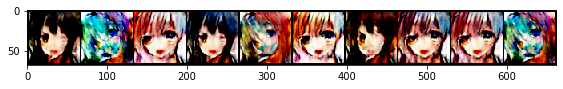

In [8]:
# Training loop

z_sample = Variable(z_sample).to(device)
steps=0
for e,epoch in enumerate(epoch_li):
    progress_bar=qqdm(dataloader)
    for b,batch in enumerate(progress_bar):
        imgs=batch
        imgs.to(device)
        
        # Traning Discriminator
        z=Variable(torch.randn(batch_size,z_dim)).to(device)
        r_imgs=Variable(imgs).to(device)
        f_imgs=G(z)
        
        r_labels=torch.ones((batch_size)).to(device)
        f_labels=torch.zeros((batch_size)).to(device)
        
        r_logit=D(r_imgs.detach())
        f_logit=D(f_imgs.detach())
        r_loss=criterion(r_logit,r_labels)
        f_loss=criterion(f_logit,f_labels)
        loss_D=(r_loss+f_loss)/2
        # WGAN Loss
        # loss_D = -torch.mean(D(r_imgs)) + torch.mean(D(f_imgs))
        
        # Model backwarding
        D.zero_grad()
        loss_D.backward()
        
        # Update the discriminator.
        opt_D.step()
        
        
        if steps % n_critic==0:
            # Generate some fake images.
            z=Variable(torch.randn(batch_size,z_dim)).to(device)
            f_imgs=G(z)
            
            # Model forwarding
            f_logit=D(f_imgs)
            
            # Compute the loss for the generator.
            G_loss=criterion(f_logit,r_labels)
            G.zero_grad()
            G_loss.backward()
            opt_G.step()
            
        G_loss_li.append(G_loss.item())
        D_loss_li.append(loss_D.item())
        steps += 1
    if epoch%3==0:
        torch.save(G.state_dict(), 'Models/G'+'%03d'%epoch+'.pth')
        torch.save(D.state_dict(), 'Models/D'+'%03d'%epoch+'.pth')
        np.savetxt('Models/G_loss.txt',np.array(G_loss_li))
        np.savetxt('Models/D_loss.txt',np.array(D_loss_li))
    
    G.eval()
    sample_imgs=G(z_sample).data
    filename='Train/'+'%03d'%epoch+'.jpg'
    torchvision.utils.save_image(sample_imgs, filename, nrow=10)
    print(f' | Save some samples to {filename}.')
    grid_img = torchvision.utils.make_grid(sample_imgs.cpu(), nrow=10)
    plt.figure(figsize=(10,1))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()
    G.train()


/home/ytshen/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


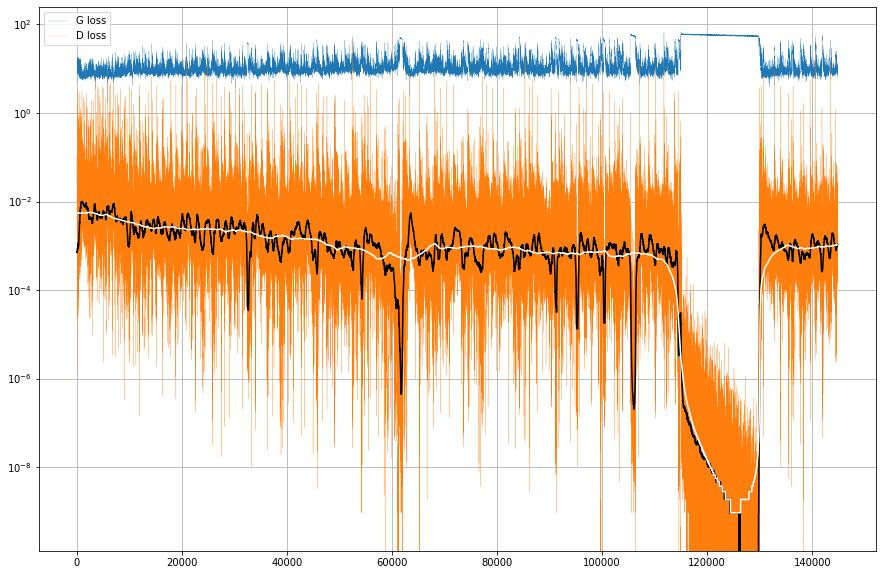

In [7]:
import pylab as plt
from  scipy import ndimage
plt.figure(figsize=(15,10))
plt.plot(G_loss_li, label='G loss',lw=0.2)
plt.plot(D_loss_li, label='D loss',lw=0.2)
filt=ndimage.median_filter(D_loss_li,size=500)
filt2=ndimage.median_filter(D_loss_li,size=10000)
plt.plot(filt,c='k')
plt.plot(filt2,c='w')
plt.semilogy()
plt.grid()
plt.legend()